In [1]:
import math
import os
import random; random.seed(42)
import shelve
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set_theme()
%matplotlib widget

import sys
sys.path.append("../src/")
import hb_dic, nmf_utils

# Single Watershed Analysis

## Load and select data

Load data as 'pd.DataFrame', and then select interested time range. 

In [2]:
watershed = "W{}".format(3)
components = ["DIC", "Ca", "Mg", "K", "Na", "SO4", "Cl", "NO3"]
df = hb_dic.load_watershed_data(watershed, components)
df = df["2000":]  # Shaughnessy et al use 2000-2017

## Clean the data
1. Drop rows with any missing values
2. Convert weight to molar mass
3. Normalize the dataframe with an assigned column (default "Na"), and drop that column
4. Divide each row 

In [3]:
preprocessor = nmf_utils.NMFPreprocessor(bootstrap=3000)
v = preprocessor.transform(df)

Normalizer: Na
Normalized matrix columns:
	['DIC' 'Ca' 'Mg' 'K' 'SO4' 'NO3' 'Cl']


## PCA

In [4]:
pca = PCA()
pca.fit(v)
print("Explained varience ratio:", pca.explained_variance_ratio_, sep="\n")
n_endmember = nmf_utils.count_endmember(pca)
print("Endmember number (explain >90% ratio):", n_endmember)

Explained varience ratio:
[0.40456371 0.21378345 0.18040108 0.11699676 0.04588389 0.02391802
 0.01445309]
Endmember number (explain >90% ratio): 4


## NMF

In [6]:
nmf = NMF(n_components=n_endmember, init="random", random_state=42, max_iter=10000, tol=1e-6)
w = nmf.fit_transform(v)  # mixing proportion
h = nmf.components_  # chemical signature
h = pd.DataFrame(h, columns=v.columns)

## Rescaling!

In [ ]:
proportion_sum = w.sum(axis=1)
log_proportion_sum = np.log(proportion_sum)
rescale_factor = proportion_sum.mean()
# Or we should use
# rescale_factor = math.e ** np.mean(log_proportion_sum)
proportion_sum /= rescale_factor

plt.figure(constrained_layout=True)
sns.histplot(proportion_sum, bins=20)

vline_fmt = {"color": "C2", "linestyle": "-."}
sum_min, sum_max = proportion_sum.min(), proportion_sum.max()
plt.axvline(sum_min, **vline_fmt)
plt.axvline(sum_max, **vline_fmt)

sigma = np.std(log_proportion_sum, ddof=1)
print(
    """
      Boundary: {:.2f}~{:.2f}
      Sigma of log-normal distribution: {:.2f}
      """.format(
        sum_min, sum_max, sigma
    )
)

## Clustering

In [59]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])

In [ ]:
Hs = []

kmeans = KMeans(n_clusters=n_endmember, n_init=10)
kmeans.fit(Hs)
kmeans.labels_

## Filtering

In [ ]:
lower_bound, upper_bound = 0.9, 1.1
sample_idx = 0
sample_data = v.iloc[sample_idx]
sample_proportion = w[sample_idx]

accepted = lower_bound <= sum(sample_proportion) <= upper_bound
if accepted:
    err = np.sum(sample_data - np.dot(sample_proportion, h))
    pass

## Heatmap H

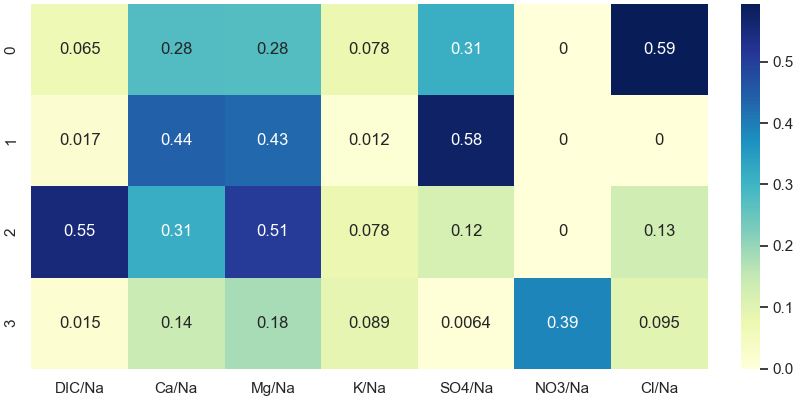

In [7]:
plt.figure(figsize=(8, 4), constrained_layout=True)
heatmap = nmf_utils.ChemistryHeatmap(h, v.columns)
heatmap.plot()

# Mutiple NMF Runs

In [2]:
watershed = "W{}".format(3)
components = ["DIC", "Ca", "Mg", "K", "Na", "SO4", "Cl", "NO3"]
df = hb_dic.load_watershed_data(watershed, components)
df = df["2000":]

In [3]:
preprocessor = nmf_utils.NMFPreprocessor(
    bootstrap=3000,
    bootstrap_random_state=42
    )
v = preprocessor.transform(df)

Normalizer: Na
Normalized matrix columns:
	['DIC' 'Ca' 'Mg' 'K' 'SO4' 'NO3' 'Cl']


In [4]:
pca = PCA()
pca.fit(v)
print("Explained variance ratio:", pca.explained_variance_ratio_, sep="\n")
n_endmember = nmf_utils.count_endmember(pca)
print("Endmember number (explain >90% ratio):", n_endmember)

Explained variance ratio:
[0.40456371 0.21378345 0.18040108 0.11699676 0.04588389 0.02391802
 0.01445309]
Endmember number (explain >90% ratio): 4


In [6]:
resizer = nmf_utils.NMFResizer()
n_trail = 5000
n_sel = 50
state = random.getstate()
sigmas = np.empty(n_trail)

for i in range(n_trail):
    rand = random.randint(0, 2**16)
    nmf = NMF(n_components=n_endmember, init="random", random_state=rand, max_iter=10000, tol=1e-6)
    w = nmf.fit_transform(v)  # mixing proportion
    h = nmf.components_  # chemical signature
    h = pd.DataFrame(h, columns=v.columns)
    #resizer.resize(w, h, inplace=True)
    resizer._init_factor(w)
    sigmas[i] = resizer.sigma

random.setstate(state)

sel_indices = np.argpartition(sigmas, n_sel)[:n_sel]

In [7]:
# Current time with a format that can be used in filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir = "../models/output/trailw3_{}/".format(timestamp)
os.mkdir(new_dir)
db = shelve.open(new_dir + "shelve")
hs = np.empty((n_sel, n_endmember, len(v.columns)))
plt.figure(figsize=(8, 4), constrained_layout=True)
j = 0
for i in range(n_trail):
    rand = random.randint(0, 2**16)
    if i in sel_indices:
        nmf = NMF(
            n_components=n_endmember,
            init="random",
            random_state=rand,
            max_iter=10000,
            tol=1e-6,
        )
        w = nmf.fit_transform(v)  # mixing proportion
        h = nmf.components_  # chemical signature
        h = pd.DataFrame(h, columns=v.columns)
        resizer.transform(w, h, inplace=True)
        db[str(i)] = h
        hs[j] = h
        j += 1

        heatmap = nmf_utils.ChemistryHeatmap(h, h.columns)
        heatmap.plot();
        plt.savefig(new_dir+"t{}.png".format(i));
        plt.clf();

plt.close()
db.close()

No such comm: b7e691ae61e447a59a38a5071348ac27


[[3 2 0 1]
 [0 2 3 1]
 [2 0 1 3]
 [3 0 2 1]
 [3 0 1 2]
 [3 2 1 0]
 [3 2 1 0]
 [3 2 0 1]
 [3 2 1 0]
 [0 2 1 3]
 [0 1 3 2]
 [3 2 0 1]
 [3 2 0 1]
 [3 2 1 0]
 [3 2 1 0]
 [0 3 2 1]
 [3 2 0 1]
 [0 3 2 1]
 [0 3 2 1]
 [3 2 0 1]
 [0 2 1 3]
 [3 2 0 1]
 [0 1 3 2]
 [0 2 3 1]
 [0 3 1 2]
 [3 0 2 1]
 [0 3 2 1]
 [0 3 1 2]
 [3 0 2 1]
 [0 2 3 1]
 [3 2 1 0]
 [3 2 1 0]
 [0 3 2 1]
 [0 3 2 1]
 [0 2 3 1]
 [0 1 2 3]
 [0 3 1 2]
 [3 2 0 1]
 [3 2 1 0]
 [3 2 1 0]
 [3 0 2 1]
 [0 3 2 1]
 [0 2 1 3]
 [2 3 0 1]
 [0 3 2 1]
 [0 2 1 3]
 [0 1 2 3]
 [0 2 1 3]
 [0 3 2 1]
 [3 0 2 1]]


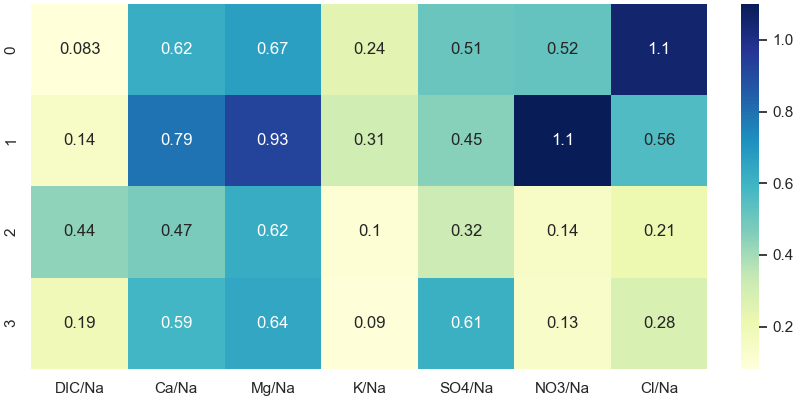

In [8]:
permuter = nmf_utils.NMFPermuter(n_endmember=n_endmember)

permuter.fit_transform(hs, inplace=True)
labels = permuter.labels
print(labels)
h_mean = hs.mean(axis=0)

plt.figure(figsize=(8, 4), constrained_layout=True)
heatmap = nmf_utils.ChemistryHeatmap()
heatmap.plot(h_mean, v.columns)
plt.savefig(new_dir + "H.png")
plt.show()